In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components,display_pca_data


In [4]:
import holoviews as hv
hv.notebook_extension()

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Hist
)

from ipywidgets import HBox, VBox, IntSlider, Play, jslink, Layout, Dropdown
import ipywidgets
%matplotlib inline

In [5]:
%%time

dataset_name = "W13_only"

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (31197, 312)
BES_numeric (31197, 299)
var_type (312, 13)
BES_non_numeric (31197, 11)
BES_reduced (31197, 304)
BES_reduced_with_na (31197, 304)
Wall time: 4.05 s


In [6]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core

Treatment = dataset_name
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [7]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

In [8]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)

# (svd_solver='full', n_components='mle',whiten=True)
#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 3.44 s


In [9]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + os.sep + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [10]:
# # %%time
# # import importlib.util
# # import utility
# # importlib.reload(utility)
# # from utility import display_components

# import imp; imp.reload(utility)
# del display_pca_data
# from utility import display_pca_data

average log-likelihood of all samples: -383.022228713
number of iterations: 2


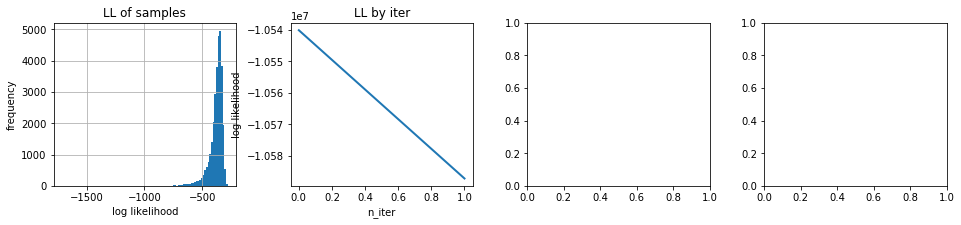

In [11]:
display_pca_data(n_components, decomp, BES_std)

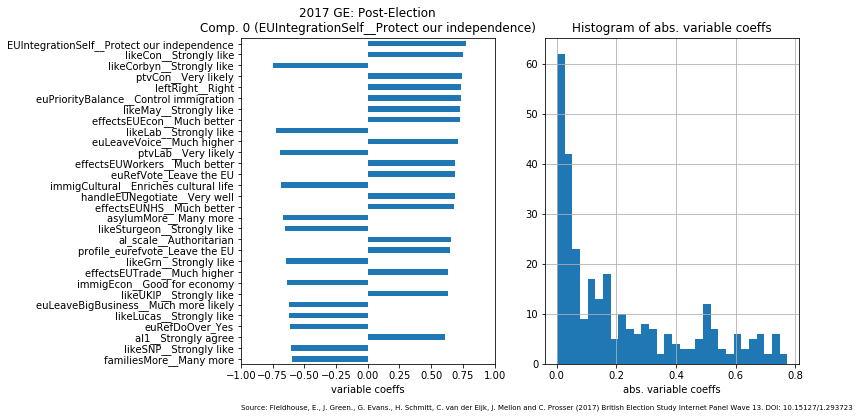

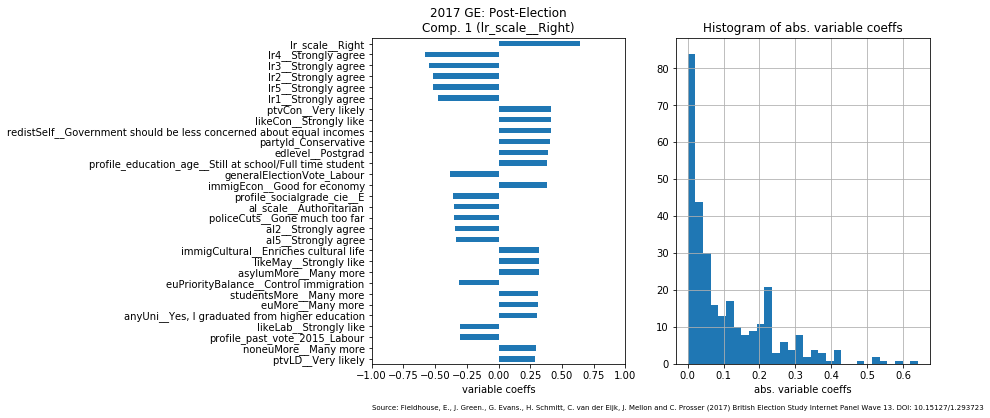

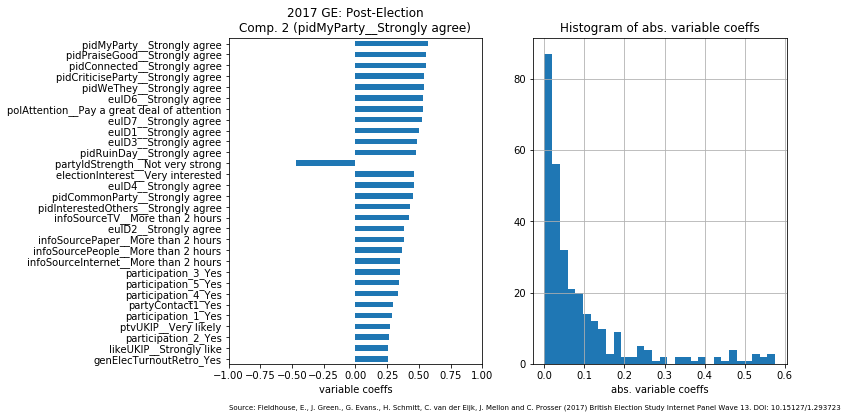

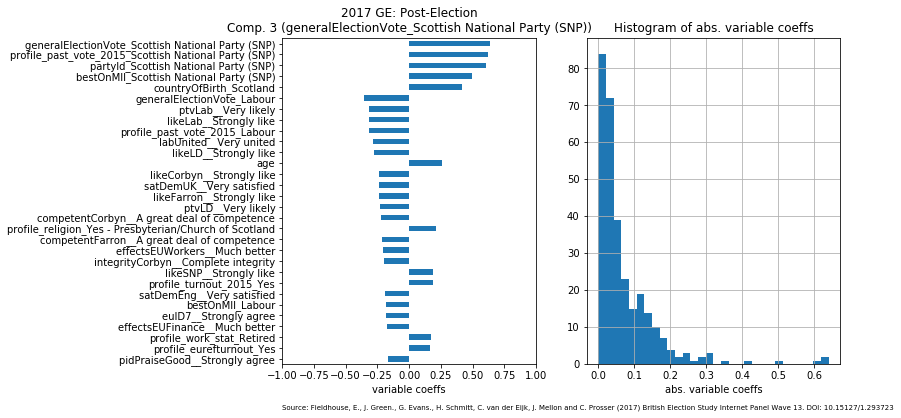

In [12]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_reduced.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = True)

In [13]:
# # returns = np.log(prices[1:]) - np.log(prices[:-1])
# hist_x = LinearScale()
# hist_y = LinearScale()
# hist = Hist(sample=comp["comp_absmag"], scales={'sample': hist_x, 'count': hist_y}, bins=30)

# hist_x.min=0
# hist_x.max=1

# h_xax = Axis(scale=hist_x, label='abs. variable coeffs', grids='off', set_ticks=True)
# h_yax = Axis(scale=hist_y, label='Freq', orientation='vertical', grid_lines='none')

# layout=ipywidgets.Layout(min_width='1000px', min_height='200px')

# fig_hist = Figure( marks=[hist], axes=[h_xax, h_yax], title='histogram of abs. variable coeffs',
#                    layout = layout, min_height='200px', preserve_aspect=False )
# fig_hist

In [14]:
from bqplot import DateScale, LinearScale, OrdinalScale, Axis, Lines, Scatter, Bars, Hist, Figure

comp_slider = IntSlider(min=0, max=19, step=1, description='Component', value=0)
def comp_changed(change):
    comp = comp_dict[comp_slider.value]
    fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
    bar_lasso.x = comp["components_"].tail(30).index
    bar_lasso.y = comp["components_"].tail(30).values
    
comp_slider.observe(comp_changed, 'value')

comp = comp_dict[0]
x = comp["components_"].tail(30).index
y = comp["components_"].tail(30).values



title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"

xs, ys = OrdinalScale(), LinearScale()
ys.min = -1
ys.max = 1

data = np.arange(20)
bar_lasso = Bars(x=x, y=y, scales={'x': xs, 'y': ys}, orientation='horizontal',font_size = '30px')
xax_lasso = Axis(scale=xs, orientation='vertical')
yax_lasso = Axis(scale=ys, label='variable coeffs', orientation='horizontal')
fig_margin = dict(top=60, bottom=60, left=320, right=60)
layout=ipywidgets.Layout(min_width='1000px', min_height='600px')
fig_lasso = Figure(marks=[ bar_lasso], axes=[xax_lasso, yax_lasso],
                   title=title, fig_margin = fig_margin,
                   layout=layout)


box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center')

VBox([ fig_lasso,  comp_slider ], layout = box_layout)

VBox(children=(Figure(axes=[Axis(orientation='vertical', scale=OrdinalScale()), Axis(label='variable coeffs', scale=LinearScale(max=1.0, min=-1.0))], fig_margin={'top': 60, 'bottom': 60, 'left': 320, 'right': 60}, layout=Layout(min_height='600px', min_width='1000px'), marks=[Bars(colors=['steelblue'], interactions={'hover': 'tooltip'}, orientation='horizontal', scales={'x': OrdinalScale(), 'y': LinearScale(max=1.0, min=-1.0)}, scales_metadata={'x': {'orientation': 'vertical', 'dimension': 'x'}, 'y': {'orientation': 'horizontal', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9}, x=array(['euRefDoOver_Yes', 'likeCon__Strongly like',
       'likeMay__Strongly like', 'blackEquality__Gone much too far',
       'immigEcon__Good for economy',
       'europeanness__Very strongly European',
       'approveEU__Strongly approve', 'overseasAid__Strongly agree',
       'ptvUKIP__Very likely', 'al_scale__Authoritarian',
       'effectsEUNHS__Much better',
       'immigrantsWelfareState__Strongly agree',
       'euLeaveBigBusiness__Much more likely',
       'effectsEUTrade__Much higher',
       'socialIdentityGlobalLeave__A great deal in common',
       'ukCoopMovement__Bad for Britain', 'effectsEUWorkers__Much better',
       'leftRight__Right', 'immigCultural__Enriches cultural life',
       'likeFarage__Strongly like', 'profile_eurefvote_Leave the EU',
       'immigSelf__Allow many more', 'euID_The leave side',
       'likeUKIP__Strongly like', 'euLeaveVoice__Much higher',
       'euRefVote_Leave the EU', 'euPriorityBalance__Control immigration',
       'effectsEUEcon__Much better',
       'EUIntegrationSelf__Protect our independence',
       'happyEULeave__Extremely happy'], dtype=object), y=array([-0.6021548 ,  0.61729716,  0.62458771,  0.62522835, -0.62982937,
       -0.63192842, -0.63737456,  0.63962888,  0.6472221 ,  0.64922858,
        0.66058002,  0.66414122, -0.66527018,  0.66528931,  0.6681943 ,
        0.67039326,  0.68030577,  0.68237693, -0.70134471,  0.7076941 ,
        0.71199831, -0.71231845,  0.7261144 ,  0.72639728,  0.72654986,
        0.73121409,  0.74573152,  0.75654623,  0.80667015,  0.81769941]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Comp. 0 (happyEULeave__Extremely happy)'), IntSlider(value=0, description='Component', max=19)), layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [15]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

# SparsePCA
if decomp_method == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [16]:
default_value = 'al_scale__Right'
if default_value not in BES_reduced.columns:
    lr_scale_var_list = [x for x in BES_reduced.columns if 'al_scale' in x]
    if len(lr_scale_var_list) > 0:
        default_value = lr_scale_var_list[0]
    else:
        default_value = BES_reduced.columns[0]

value_selector = Dropdown(
    options=list( BES_reduced.columns ),
    value= default_value,
    description='BES Variable:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

def value_changed(change):
    print(value_selector.value)
#     comp = comp_dict[comp_slider.value]
#     fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
#     bar_lasso.x = comp["components_"].tail(30).index
#     bar_lasso.y = comp["components_"].tail(30).values
    
value_selector.observe(value_changed, 'value')
value_selector

Dropdown(description='BES Variable:', index=194, options=('turnoutUKGeneral__Very likely that I will vote', 'generalElectionCertainty__Completely certain', 'partyIdStrength__Not very strong', 'happyEULeave__Extremely happy', 'expectGoodConductEURef__Conducted unfairly', 'polAttention__Pay a great deal of attention', 'britishness__Very strongly British', 'englishness__Very strongly English', 'europeanness__Very strongly European', 'likeMay__Strongly like', 'likeCorbyn__Strongly like', 'likeFarron__Strongly like', 'likeFarage__Strongly like', 'likeLucas__Strongly like', 'likeNuttal__Strongly like', 'trustMPs__A great deal of trust', 'happyTrump__Extremely happy', 'majorityPartyCon__Very likely', 'majorityPartyLab__Very likely', 'likeCon__Strongly like', 'likeLab__Strongly like', 'likeLD__Strongly like', 'likeUKIP__Strongly like', 'likeGrn__Strongly like', 'approveUKGovt__Strongly approve', 'approveEU__Strongly approve', 'conUnited__Very united', 'labUnited__Very united', 'ldUnited__Very united', 'ukipUnited__Very united', 'grnUnited__Very united', 'goodTimePurchase__Good time to buy', 'riskPoverty__Very likely', 'riskUnemployment__Very likely', 'econPersonalRetro__Got a lot better', 'econGenRetro__Got a lot better', 'econPersonalProsp__Get a lot better', 'econGenProsp__Get a lot better', 'redistSelf__Government should be less concerned about equal incomes', 'redistCon__Government should be less concerned about equal incomes', 'redistLab__Government should be less concerned about equal incomes', 'redistLD__Government should be less concerned about equal incomes', 'redistUKIP__Government should be less concerned about equal incomes', 'redistGreen__Government should be less concerned about equal incomes', 'antiIntellectual__Strongly agree', 'efficacyUnderstand__Strongly agree', 'efficacyTooMuchEffort__Strongly agree', 'efficacyNotUnderstand__Strongly agree', 'efficacyPolCare__Strongly agree', 'efficacyNoMatter__Strongly agree', 'radical__Strongly agree', 'harkBack__Strongly agree', 'gayMarriage__Strongly agree', 'womenJobs__Strongly agree', 'genderRoles__Strongly agree', 'renationaliseRail__Strongly agree', 'overseasAid__Strongly agree', 'EUIntegrationSelf__Protect our independence', 'satDemUK__Very satisfied', 'satDemEng__Very satisfied', 'satDemEU__Very satisfied', 'controlImmig__Complete control', 'handleEUNegotiate__Very well', 'euPriorityBalance__Control immigration', 'ukCoopTrade__Bad for Britain', 'ukCoopMovement__Bad for Britain', 'socialIdentityGlobalLeave__A great deal in common', 'socialIdentityGlobalRemain__A great deal in common', 'effectsEUUnemployment__Much higher', 'effectsEUTrade__Much higher', 'effectsEUImmigration__Much higher', 'effectsEUTerror__Much higher', 'euLeaveVoice__Much higher', 'effectsEUWorkers__Much better', 'effectsEUEcon__Much better', 'effectsEUFinance__Much better', 'effectsEUNHS__Much better', 'euLeaveBigBusiness__Much more likely', 'euLeaveScotIndep__Much more likely', 'UKsovereigntyPost__Strongly agree', 'euID1__Strongly agree', 'euID2__Strongly agree', 'euID3__Strongly agree', 'euID4__Strongly agree', 'euID6__Strongly agree', 'euID7__Strongly agree', 'immigEcon__Good for economy', 'immigCultural__Enriches cultural life', 'immigSelf__Allow many more', 'immigCon__Allow many more', 'immigLab__Allow many more', 'immigLD__Allow many more', 'immigUKIP__Allow many more', 'immigGreen__Allow many more', 'leaveImpactSelf__A very large impact', 'leaveImpactBritain__A very large impact', 'ptvCon__Very likely', 'ptvLab__Very likely', 'ptvLD__Very likely', 'ptvUKIP__Very likely', 'ptvGrn__Very likely', 'changeEconomy__Getting a lot better', 'changeNHS__Getting a lot better', 'changeEducation__Getting a lot better', 'changeCostLive__Getting a lot higher', 'changeImmig__Getting a lot higher', 'changeCrime__Getting a lot higher', 'changeEconomyLab__Getting a lot better', 'changeNHSLab__Getting a lot better', 'changeEducationLab__Getting a lot better', 'changeCostLiveLab__Getting a lot higher', 'changeImmigLab

In [17]:
from bqplot import *
sc_x = LinearScale()
sc_y = LinearScale()
sc_col = ColorScale(colors=['red', 'white', 'green'], mid=0.0)
decomp_label_col = value_selector.value
size = 100

x_data = BES_decomp.loc[ :, x_axis ]
y_data = BES_decomp.loc[ :, y_axis ]

scatt_1 = Scatter(x=x_data,
                  y=y_data[:50],
                  color=BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
                  scales={'x': sc_x, 'y': sc_y, 'color': sc_col})
scatt_2 = Scatter(x=x_data, y=y_data[:50] * 2, color=y_data[:50] * 2, scales={'x': sc_x, 'y': sc_y, 'color': sc_col}, 
               preserve_domain={'color': True}, marker='cross')

ax_x = Axis(scale=sc_x)
ax_y = Axis(scale=sc_y, orientation='vertical')
Figure(marks=[scatt_1, scatt_2], axes=[ax_x, ax_y])

Figure(axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Scatter(color=array([ 16.,   9.,  15., ...,  18.,   8.,   4.]), colors=['steelblue'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale(), 'color': ColorScale(colors=['red', 'white', 'green'], mid=0.0)}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([ 1.54703451,  0.41464877, -0.01415133, ...,  0.55785977,
       -0.60375487, -1.91534325]), y=array([-2.16188   ,  1.72130146, -0.72215767, -1.50270145,  0.94012297,
        1.18931935,  1.6229847 ,  1.79877445,  1.46746478,  0.76865897,
        0.00328055, -0.57413248,  0.98878499, -2.26191678,  1.21532273,
        0.93199955, -0.32303917, -0.21526696,  0.2416261 ,  0.39262099,
        2.33128278, -0.11225678,  2.425913  ,  1.27613909, -0.24187242,
        2.26122985, -0.53906087,  1.1848756 ,  1.63005448, -0.54252628,
        0.20758178,  0.78376782,  0.22651185,  0.37479461,  0.8944208 ,
        0.77939228, -1.14206058,  0.04073444,  0.04945195,  1.35081835,
        0.87737645,  2.99966552,  0.44061889, -0.22707268, -0.36193075,
        0.88456602,  0.28464193,  0.84737708,  1.54976761,  1.47948669])), Scatter(color=array([-4.32376001,  3.44260291, -1.44431533, -3.00540289,  1.88024594,
        2.3786387 ,  3.24596941,  3.5975489 ,  2.93492957,  1.53731793,
        0.0065611 , -1.14826497,  1.97756999, -4.52383355,  2.43064546,
        1.8639991 , -0.64607834, -0.43053393,  0.4832522 ,  0.78524198,
        4.66256555, -0.22451356,  4.851826  ,  2.55227818, -0.48374484,
        4.5224597 , -1.07812175,  2.36975121,  3.26010897, -1.08505255,
        0.41516356,  1.56753563,  0.45302371,  0.74958922,  1.7888416 ,
        1.55878456, -2.28412115,  0.08146887,  0.09890391,  2.70163671,
        1.7547529 ,  5.99933104,  0.88123778, -0.45414535, -0.72386149,
        1.76913205,  0.56928385,  1.69475416,  3.09953522,  2.95897339]), colors=['steelblue'], interactions={'hover': 'tooltip'}, marker='cross', preserve_domain={'color': True}, scales={'x': LinearScale(), 'y': LinearScale(), 'color': ColorScale(colors=['red', 'white', 'green'], mid=0.0)}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([ 1.54703451,  0.41464877, -0.01415133, ...,  0.55785977,
       -0.60375487, -1.91534325]), y=array([-4.32376001,  3.44260291, -1.44431533, -3.00540289,  1.88024594,
        2.3786387 ,  3.24596941,  3.5975489 ,  2.93492957,  1.53731793,
        0.0065611 , -1.14826497,  1.97756999, -4.52383355,  2.43064546,
        1.8639991 , -0.64607834, -0.43053393,  0.4832522 ,  0.78524198,
        4.66256555, -0.22451356,  4.851826  ,  2.55227818, -0.48374484,
        4.5224597 , -1.07812175,  2.36975121,  3.26010897, -1.08505255,
        0.41516356,  1.56753563,  0.45302371,  0.74958922,  1.7888416 ,
        1.55878456, -2.28412115,  0.08146887,  0.09890391,  2.70163671,
        1.7547529 ,  5.99933104,  0.88123778, -0.45414535, -0.72386149,
        1.76913205,  0.56928385,  1.69475416,  3.09953522,  2.95897339]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0))

In [18]:
# BES_decomp_with_na = BES_decomp
# BES_decomp_with_na[ BES_reduced_with_na.isnull().values ] = np.nan

In [19]:
gc.collect()

0

In [20]:
# BES_decomp

In [21]:
# BES_decomp_with_na

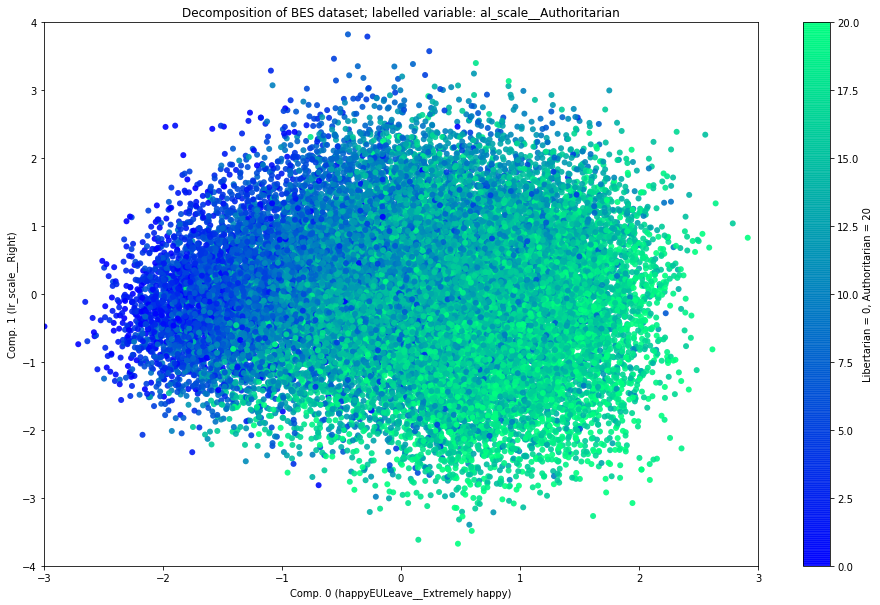

In [22]:
# for ordinal categorical
# winter, autumn
%matplotlib inline
cmap_name = "winter"
decomp_label_col = value_selector.value
label_stub = decomp_label_col.split("__")[0]

fig = plt.figure( figsize=(16,10) )
plt.scatter(BES_decomp.loc[ :, x_axis ],
            BES_decomp.loc[ :, y_axis ],
            cmap = plt.get_cmap(cmap_name),
            c = BES_reduced_with_na.loc[BES_decomp.index,decomp_label_col].values,
            edgecolor = "None",
            alpha = 0.9) #            edgecolors=col,

plt.xlim(xlim) #cats
plt.ylim(ylim)
if label_stub in cat_dictionary.keys():
    cats = cat_dictionary[ label_stub ]
    labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.show()

fig.savefig( output_subfolder + decomp_method+ os.sep +label_stub+".png", bbox_inches='tight' )

In [23]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

noise_variance_
happyEULeave__Extremely happy                              0.215972
lr_scale__Right                                            0.257714
al_scale__Authoritarian                                    0.273408
likeCon__Strongly like                                     0.278952
EUIntegrationSelf__Protect our independence                0.282166
likeUKIP__Strongly like                                    0.290889
profile_newspaper_readership_201_The Independent           0.315832
ptvCon__Very likely                                        0.316666
effectsEUEcon__Much better                                 0.323742
euRefVote_Leave the EU                                     0.326960
likeLab__Strongly like                                     0.327429
euID_The leave side                                        0.335392
ptvUKIP__Very likely                                       0.338289
likeFarage__Strongly like                                  0.339570
profile_eurefvote_Leave the EU                             0.346452
ptvLab__Very likely                                        0.348816
likeMay__Strongly like                                     0.355552
education_Scottish Higher Certificate                      0.355941
approveUKGovt__Strongly approve                            0.359692
generalElectionVote_Scottish National Party (SNP)          0.367322
immigSelf__Allow many more                                 0.377284
euPriorityBalance__Control immigration                     0.381109
immigCultural__Enriches cultural life                      0.389947
euLeaveVoice__Much higher                                  0.398070
profile_past_vote_2015_Scottish National Party ...         0.403267
leftRight__Right                                           0.407869
partyId_Scottish National Party (SNP)                      0.408826
changeEconomyLab__Getting a lot better                     0.410773
likeCorbyn__Strongly like                                  0.411163
edlevel__Postgrad                                          0.424286
...                                                             ...
gor_East of England                                        0.899957
gor_Yorkshire and the Humber                               0.901601
countryOfBirth_Other: Commonwealth member country          0.904002
countryOfBirth_Other: Rest of world                        0.905538
gor_South West                                             0.906604
gor_West Midlands                                          0.912196
education_City and Guild certificate                       0.914456
gor_East Midlands                                          0.915295
headHouseholdPast_My mother                                0.918009
countryOfBirth_Republic of Ireland                         0.918012
education_Scottish Ordinary/ Lower Certificate             0.920875
xprofile_newspaper_readership_The Independent              0.921286
education_University diploma                               0.924636
education_Teaching qualification (not degree)              0.925454
xprofile_ethnicity_Chinese                                 0.925512
education_CSE grades 2-5                                   0.928183
education_Clerical and commercial                          0.928344
gor_North East                                             0.933128
xsexuality_Bisexual                                        0.934034
education_Nursing qualification (eg SEN, SRN, S...         0.940488
headHouseholdPast_Someone else                             0.941876
education_City and Guild certificate - advanced            0.943426
headHouseholdPast_No one in my house worked                0.947188
education_Recognised trade apprenticeship compl...         0.950526
bestOnMII_Other party                                      0.957582
education_Youth training certificate/skillseekers          0.962312
profile_past_vote_2005_Veritas                             0.963246
education_onc                           

noise_variance_
bestOnMII_Other party                                      0.957582
countryOfBirth_Northern Ireland                            0.966374
countryOfBirth_Other: Commonwealth member country          0.904002
countryOfBirth_Other: Rest of world                        0.905538
countryOfBirth_Republic of Ireland                         0.918012
education_CSE grades 2-5                                   0.928183
education_City and Guild certificate                       0.914456
education_City and Guild certificate - advanced            0.943426
education_Clerical and commercial                          0.928344
education_Nursing qualification (eg SEN, SRN, S...         0.940488
education_Recognised trade apprenticeship compl...         0.950526
education_Scottish Ordinary/ Lower Certificate             0.920875
education_Teaching qualification (not degree)              0.925454
education_University diploma                               0.924636
education_Youth training certificate/skillseekers          0.962312
education_onc                                              0.963759
gor_East Midlands                                          0.915295
gor_North East                                             0.933128
gor_South West                                             0.906604
gor_West Midlands                                          0.912196
gor_Yorkshire and the Humber                               0.901601
headHouseholdPast_My mother                                0.918009
headHouseholdPast_No one in my house worked                0.947188
headHouseholdPast_Someone else                             0.941876
profile_past_vote_2005_Veritas                             0.963246
profile_past_vote_2015_British National Party (...         0.963871
xprofile_ethnicity_Chinese                                 0.925512
xprofile_newspaper_readership_The Independent              0.921286
xsexuality_Bisexual                                        0.934034

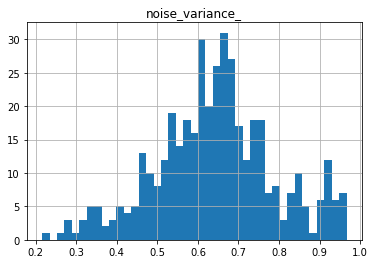

In [23]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [25]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

In [26]:
###### CLUSTERING ##############

In [27]:

# affinity_propagation = cluster.AffinityPropagation(damping=.9,
#                                                    preference=-200)

# affinity_propagation.fit(X[:,0:2])

# dbscan = cluster.DBSCAN(eps=.2)
# dbscan.fit(X)

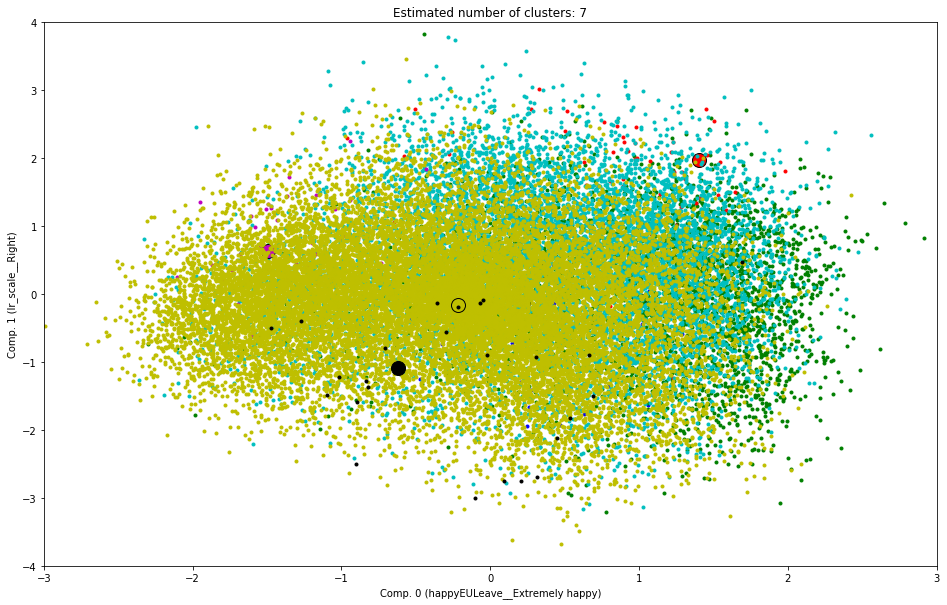

In [28]:
from sklearn import cluster
X = X_r

two_means = cluster.MiniBatchKMeans(n_clusters=7)
two_means.fit(X)

labels = two_means.labels_
cluster_centers = two_means.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)

In [29]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [30]:
labels, centroids, X_hat = kmeans_missing(BES_reduced_with_na, n_clusters=5)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\cluster\k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [31]:
gc.collect()

6

number of estimated clusters : 2
Wall time: 22.4 s


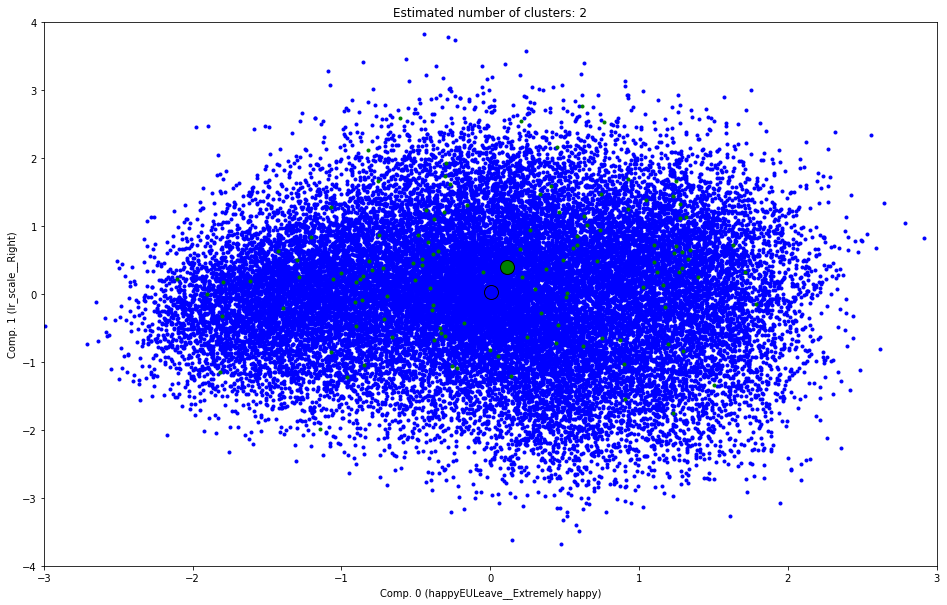

In [32]:
%%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(output_subfolder + decomp_method+ os.sep +"Cluster_estimation.png",bbox_inches='tight')


In [33]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [34]:
# BES_reduced.columns

In [35]:
# BES_Panel["riskScale"]

In [36]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


personality_agreeableness
personality_conscientiousness
personality_extraversion
personality_neuroticism
personality_openness


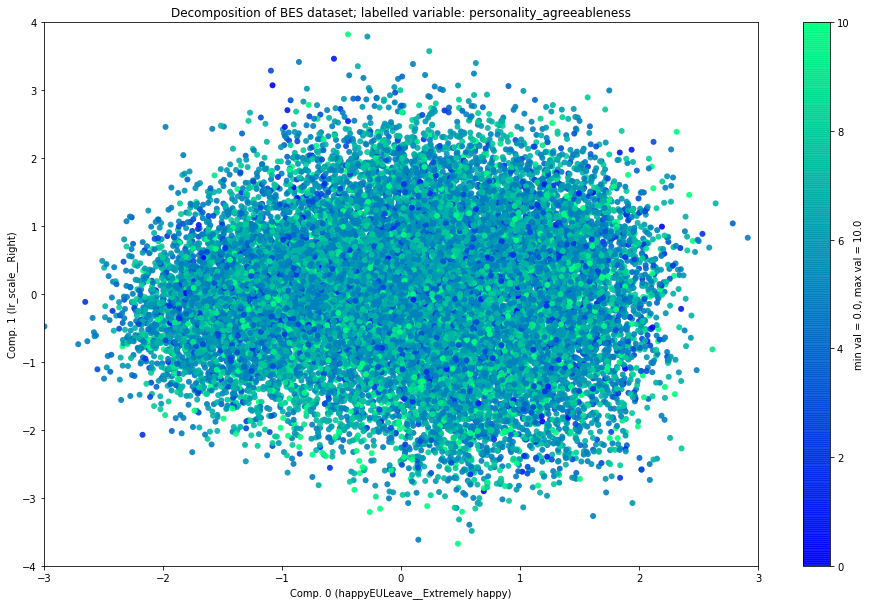

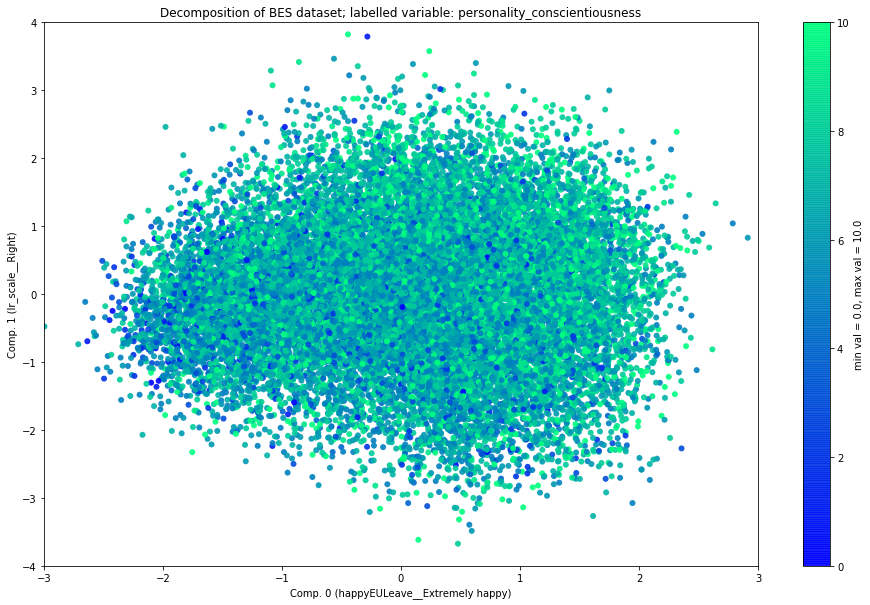

In [24]:
# %%time

graph_type = "ordinal_scatter/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

cmap_name = "winter"
    
dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:

#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

#     # go through all the variables that have been created from base variables through transformation
#     # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
#     decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
#     if len(decomp_label_categories) == 0: # removed during transformation/reduction
#         continue
#     elif len(decomp_label_categories) > 1:
#         raise Exception('len(decomp_label_categories) > 1 !!!')
#     # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    #### NEEDS FIXING!!!
    
    if (decomp_label_col not in BES_reduced.columns):
        if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
            decomp_label_categories = new_old_col_names[decomp_label_col]
        else:
            continue ## variable removed in transformation
    else:
        decomp_label_categories = decomp_label_col
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced_with_na.loc[ BES_decomp.index , decomp_label_categories],
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5 ]: #6 already numerical
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0, 6 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories]
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    print(decomp_label_col)
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

Wall time: 43.7 s


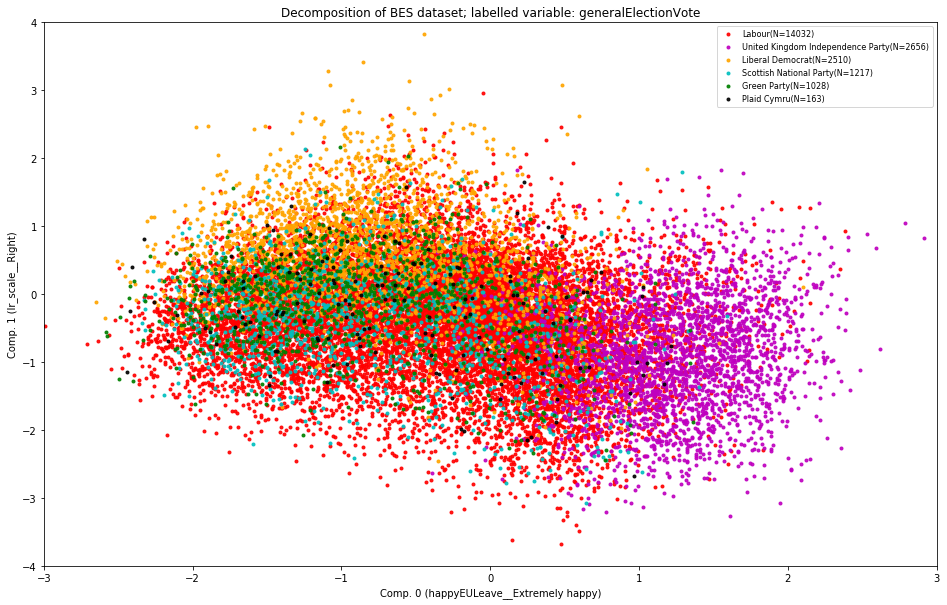

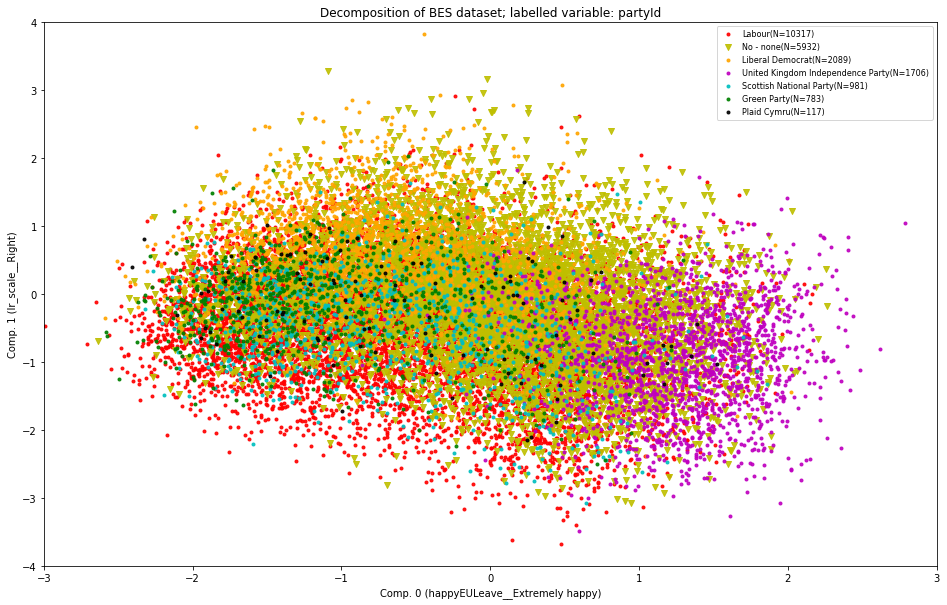

In [38]:
%%time

graph_type = "non_ordinal_scatter/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced_with_na.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue
        
#     if (decomp_label_col not in BES_reduced.columns):
#         if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
#             decomp_label_categories = new_old_col_names[decomp_label_col]
#         else:
#             continue ## variable removed in transformation
#     else:
#         decomp_label_categories = decomp_label_col        

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced_with_na[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced_with_na[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [39]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [40]:
# BES_numeric['riskScale'].astype('category')
# df[col].value_counts()
# [str(x) for x in df[col].cat.categories]
# df[col].value_counts().values

In [36]:
# new_old_col_names

{'EUIntegrationSelf__Protect our independence': 'EUIntegrationSelf',
 'UKsovereigntyPost__Strongly agree': 'UKsovereigntyPost',
 'achieveReduceImmigCon_Yes': 'achieveReduceImmigCon',
 'achieveReduceImmigDK_Yes': 'achieveReduceImmigDK',
 'achieveReduceImmigLab_Yes': 'achieveReduceImmigLab',
 'achieveReduceImmigNone_Yes': 'achieveReduceImmigNone',
 'achieveReduceImmigUKIP_Yes': 'achieveReduceImmigUKIP',
 'ageGroup__66+': 'ageGroup',
 'al1__Strongly agree': 'al1',
 'al2__Strongly agree': 'al2',
 'al3__Strongly agree': 'al3',
 'al4__Strongly agree': 'al4',
 'al5__Strongly agree': 'al5',
 'al_scale__Authoritarian': 'al_scale',
 'antiIntellectual__Strongly agree': 'antiIntellectual',
 'anyUni__Yes, I graduated from higher education': 'anyUni',
 'approveEU__Strongly approve': 'approveEU',
 'approveUKGovt__Strongly approve': 'approveUKGovt',
 'beliefTradeoff__Strongly agree': 'beliefTradeoff',
 'bestOnMII_Conservative': 'bestOnMII',
 'bestOnMII_Green Party': 'bestOnMII',
 'bestOnMII_Labour': '

Wall time: 2min 10s


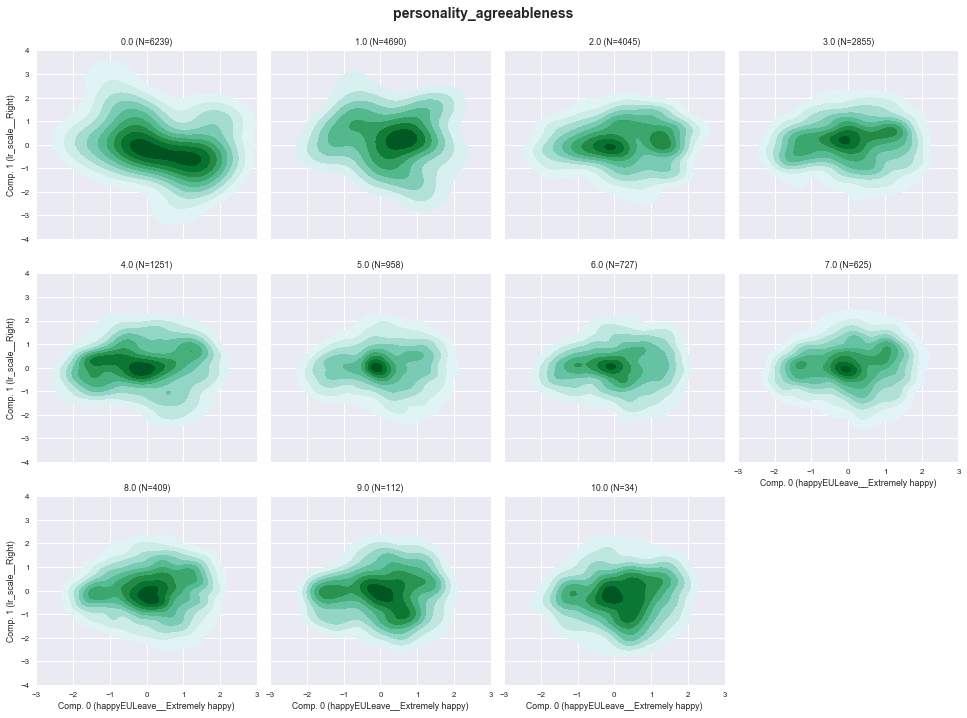

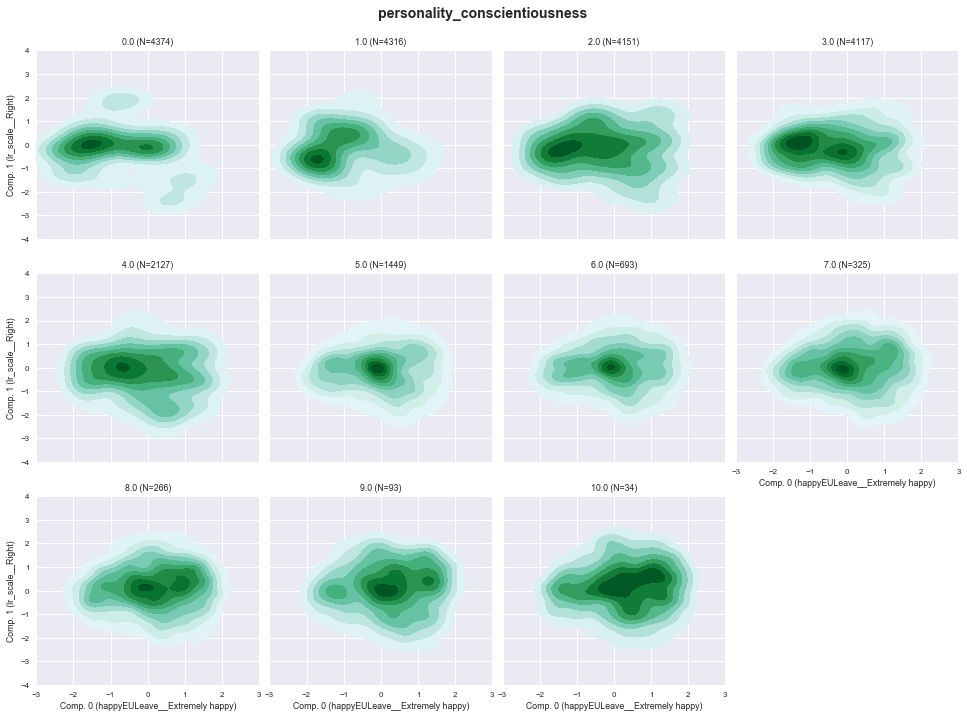

In [38]:
%%time

graph_type = "ordinal_kde/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ BES_numeric[col].notnull(),
                         [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [39]:
# BES_reduced_with_na["happyEULeave__Extremely happy"].notnull()
# BES_decomp.loc[ BES_reduced_with_na["happyEULeave__Extremely happy"].notnull() , [x_axis,y_axis] ]

Wall time: 10min 48s


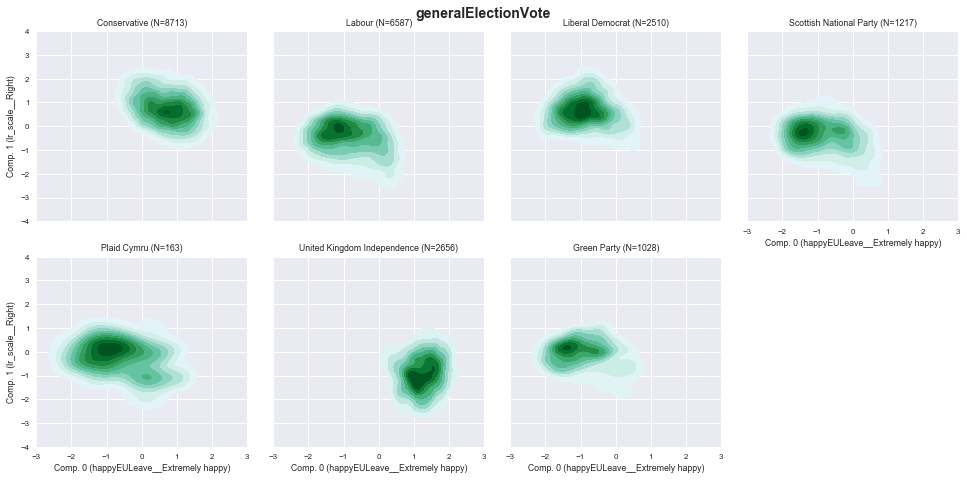

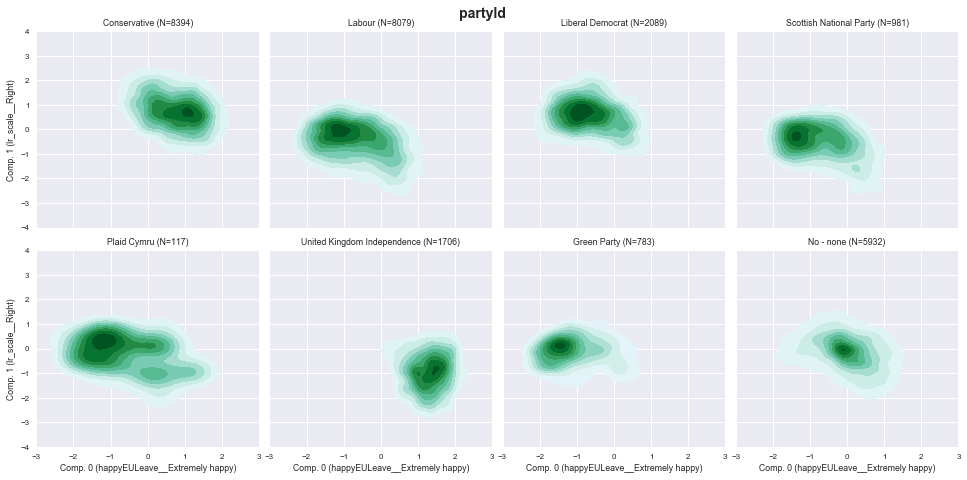

In [40]:
%%time
# 10 minutes!
max_cats = 30 # maximum number of categories

graph_type = "non_ordinal_kde/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ BES_numeric[col].notnull(),
                         [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    # so it only contains categories *that exist in this column*
    cats = list( cat_dictionary[col][ list(BES_numeric[col].astype('category').cat.categories.astype('int')) ] )
    
    num_cats = len( cats )
    
    if num_cats > max_cats:
        print(col,"has more than max_cats categories",max_cats,"so skipping")
        continue
    
    for catno in range( num_cats ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [41]:
# %debug

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\seaborn\distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


Wall time: 23.2 s


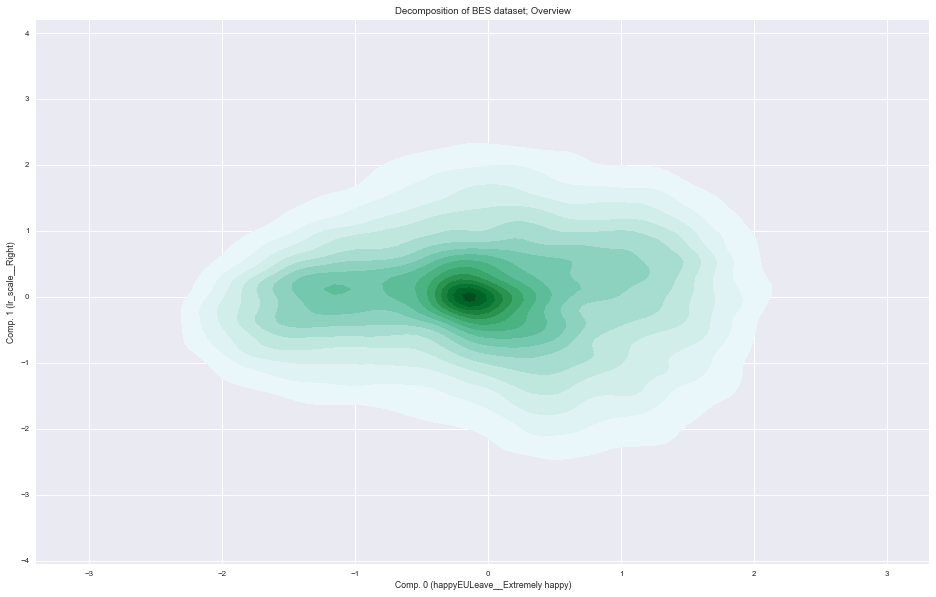

In [44]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(output_subfolder + decomp_method + os.sep + "overview"+"_kde", bbox_inches='tight')

In [45]:
col

'profile_religion_denom'

In [46]:
# %%time
# # Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# #(31409, 733)

# # BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

# print( BES_Panel.shape )

In [47]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
# print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

In [48]:
# #create mesh grid
# x = np.linspace(xlim[0], xlim[1], 100)
# y = np.linspace(ylim[0], ylim[1], 100)
# xx, yy = np.meshgrid(x, y)

In [49]:
# #Evaluate the kde on a grid
# pdf = gaussian_kde(samples.values, weights=weights.values)
# zz = pdf((np.ravel(xx), np.ravel(yy)))
# zz = np.reshape(zz, xx.shape)

In [50]:
# gc.collect()

In [51]:
# kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

In [52]:
# plt.figure()
# plt.imshow(zz, **kwargs)
# plt.title('kde')
# plt.tight_layout()
# plt.show()

In [53]:
# from matplotlib import mlab, cm
# levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
# norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
# cmap = cm.PRGn
# cset1 = plt.contourf(xx, yy, zz, levels,
#                  cmap=cm.get_cmap(cmap, len(levels) - 1),
#                  norm=norm,
#                  )

In [54]:
%%time
BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
# weights = BES_Panel['wt_full_W8']
if 'wt_core_W8' in BES_Panel.columns:
    weights = BES_Panel['wt_core_W8'].dropna()
    print(weights.shape)

    # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
    samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
    samples = np.swapaxes(samples,0,1)
    print(samples.shape)


    weighted_kde(xlim, ylim, samples, weights)

SyntaxError: invalid syntax (<unknown>, line 3)

In [ ]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [ ]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_non_numeric['wt_new_W13'].copy()#.dropna()
#BES_Panel['wt_full_W8'].dropna()

# there's a nan right at this point and nowhere else!
row_weights.loc[5987] = 1.0

print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)


demographic_moderator = 5

row_weights = ((row_weights-1)/demographic_moderator) + 1


row_weights.hist(bins=200)
print( row_weights.min(),row_weights.max() )

In [ ]:
# subsample
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()

# BES_reduced = BES_reduced_with_na.copy()
# BES_reduced = BES_reduced.copy()
missing_value_matrix = BES_reduced_with_na.notnull().astype('int')
missing_value_matrix[missing_value_matrix==0] = .25


In [ ]:
# multiply binary null/notnull matrix by the weights for each row (individual)
weights = missing_value_matrix.apply(lambda x: x*row_weights)
# weights = BES_reduced.notnull().astype('int') # just missing values
# weights = missing_value_matrix
weights = weights/weights.mean().mean()

In [ ]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )

In [ ]:
# "weightPCAreduced_withPP/" - 2% reduced data
# "weightPCAreduced_withPP/"
# Treatment = "weightPCAuptodate"
# Treatment = "sklearnPCAuptodate"
# Treatment = "weightPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCA_W10_only"
Treatment = "WPCA_W13_only"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [ ]:
%%time
from wpca import WPCA, EMPCA
from sklearn.decomposition import PCA
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
# decomp = WPCA() # 21 minutes, 7min 54s (14min 34s) -> rubbish
# decomp = WPCA(n_components=10) # 6.2s -> rubbish
# decomp = WPCA(n_components=30) # 7min 22s -> rubbish
# decomp = EMPCA(n_components=10) # 6.2s # 20min 29s -> and rubbish
#decomp = EMPCA() # more than 8 hours - had to interrupt
# weights = []

# 20s with weights, 7mins with no weights (weird!)
decomp = EMPCA(n_components=4) # super slow!
#decomp = WPCA(n_components=4) #332ms # (n_components=30)
# decomp = PCA() # svd_solver='full' # 2s


decomp_method = str(decomp).split("(")[0]
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0 or decomp_method == "PCA":
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


In [ ]:
gc.collect()

In [ ]:
subdir = BES_data_folder+"/"+Treatment+"/"+decomp_method+"/"
if not os.path.exists(subdir): os.makedirs(subdir)


In [ ]:
display_pca_data(n_components, decomp, BES_std)

In [ ]:
# %%time
# # BES_decomp, comp_labels, comp_dict = display_components(n_components, decomp, subdir, BES_reduced.columns, BES_decomp)
# (BES_decomp, comp_labels,comp_dict) = display_components(n_components, decomp.components_,
#                                                          subdir + os.sep, BES_reduced.columns, BES_decomp)

# treatdir = BES_data_folder+"W13_Lab_lost"
# if not os.path.exists(treatdir): os.makedirs(treatdir)

# decomp_method = str(decomp).split("(")[0] 
# decomp_method_subdir = treatdir + os.sep + decomp_method
# if not os.path.exists(decomp_method_subdir): os.makedirs(decomp_method_subdir)
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_reduced.columns, BES_decomp,
                                                          save_folder = subdir, 
                                                          show_first_x_comps= 20, show_histogram = True)



In [ ]:
W5vars = [x for x in BES_reduced.columns if "W5" in x]

In [ ]:
len(W5vars)

In [ ]:
# W5corr = BES_non_numeric["CampaignDayW5"].corr( BES_reduced[W5vars] )
W5corr = BES_reduced[W5vars].corrwith(BES_non_numeric["CampaignDayW5"])
# BES_non_numeric["CampaignDayW5"].corr(  )

In [ ]:
W5corr.sort_values(ascending=False)

In [ ]:
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

In [ ]:
[x for x in BES_reduced.columns if "likeBennett" in x]


In [ ]:
variable = 'likeBennettW5__Strongly like'
# "labPartnerSNPW5_Would join Labour"
crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                       columns = BES_reduced[ variable ],
                       values  = BES_non_numeric[ "wt_daily_W5" ],
                       aggfunc = sum,
                       normalize='index')

x_axis = "Campaign Day"
y_axis = variable
x_dim = hv.Dimension(x_axis, values = crosstab.index)
y_dim = hv.Dimension(y_axis, unit = '%')#, soft_range = (0,100))
hv.Curve(crosstab.unstack() * 100,
                           kdims = [x_dim] ,
                           vdims = [y_dim] )

In [ ]:
( x for x in zip(range(0, int(BES_reduced[ variable ].max())),crosstab.columns) )

In [ ]:
hmap_of_curves =  hv.HoloMap(kdims=['$variable$'])

# var_list = ['likeBennettW5__Strongly like', "labPartnerSNPW5_Would join Labour"]
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

for var_no in range(len(var_list)):
#     print(variable)
    variable = var_list[var_no]

    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ variable ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')
#     crosstab.columns = cat_dictionary[new_old_col_names[variable]]    

#     curves = hv.NdOverlay(key_dimensions=['$stuff$'] )
    
#     for value in range(0, 1+int(BES_reduced[ variable ].max()) ):
# #         col_variable = crosstab.columns[value]
#         curves[value] = hv.Curve(crosstab[value]*100,
#                                 kdims=['$x$'],
#                                 vdims=['$\\phi(x;stuff)$'], label = variable) 
#     hmap_of_curves[var_no] = curves
    col_variable = int(BES_reduced[ variable ].max())
    hmap_of_curves[var_no] = hv.Curve( crosstab[col_variable] * 100,
                                kdims=['$x$'],
                                vdims=['$\\phi(x;stuff)$'], label = variable)
    
hmap_of_curves

In [ ]:
    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ 'noChanceCoalitionLDW5_Yes' ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')

In [ ]:
[x for x in BES_reduced.columns if "Age" in x]